# Import Data

In [1]:
# helper.py
from helper import *
gc.collect()

0

In [9]:
# load data
df = pd.read_csv('./data/clean/fantasy_data.csv')

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

# rename target col
df = df.rename(columns={'PPGTarget_half-ppr': 'target'})

# drop rows with '2TM', '3TM', '4TM' values
df = df[~df['Tm'].isin(['2TM', '3TM', '4TM'])].reset_index(drop=True)

# Stacking
Is their a correlation between positional fantasy points on the same team?

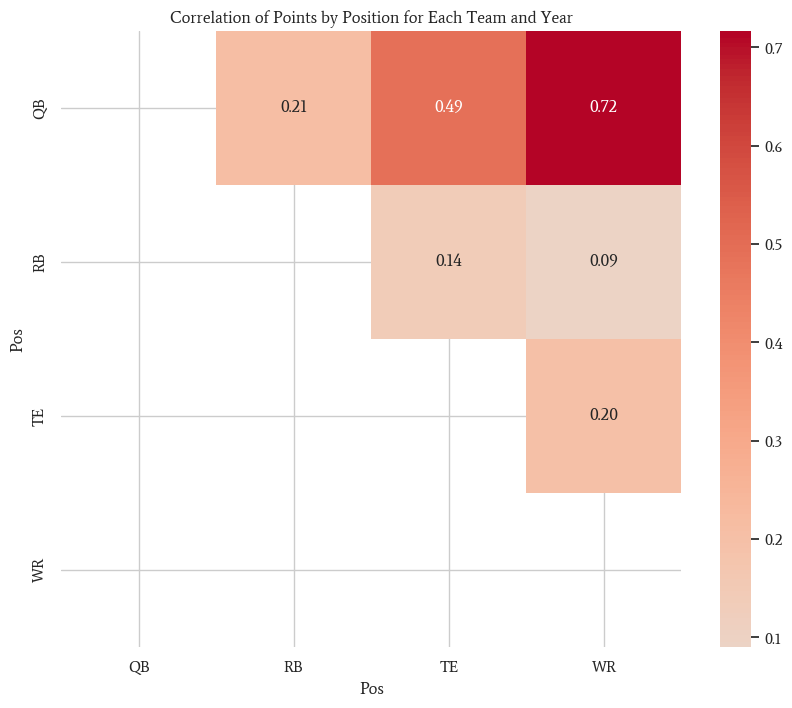

In [10]:
# calculate total points for each (Tm, Pos) combo
pos_points = df.groupby(['Tm', 'Year', 'Pos'])['Points_half-ppr'].sum().reset_index()

# Pivot the data to create columns for each position's points
pivot = pos_points.pivot_table(index=['Tm', 'Year'], columns='Pos', values='Points_half-ppr')

# plot heatmap
plot_heatmap(pivot, 'Correlation of Points by Position for Each Team and Year')

- RBs correlate very little with other positions.
- WR performance has a strong correlation with QB production, while TE correlation is moderate.

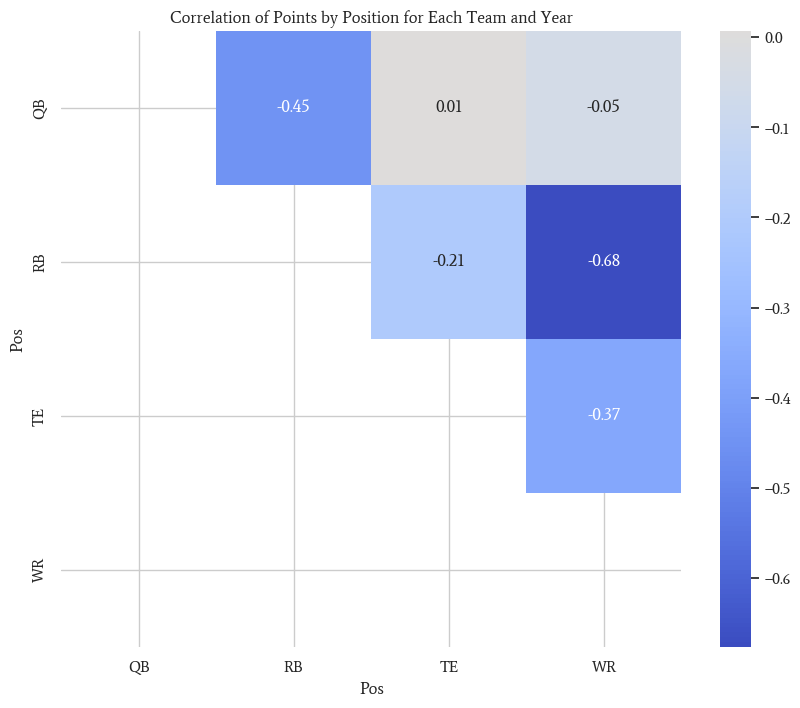

In [11]:
# for each (Tm, Year) group, calculate the percentage of points for each position
pos_points['Points_half-ppr_pct'] = pos_points['Points_half-ppr'] / pos_points.groupby(['Tm', 'Year'])['Points_half-ppr'].transform('sum')

# Pivot the data to create columns for each position's points percentage
pivot_pct = pos_points.pivot_table(index=['Tm', 'Year'], columns='Pos', values='Points_half-ppr_pct')

# plot heatmap
plot_heatmap(pivot_pct, 'Correlation of Points by Position for Each Team and Year')

- RB team production has a strong negative corr with WRs, a moderate negative corr with QBs, and a weak negative corr with TEs.
- WR team production has a moderate negative corr with TEs.

# Rookie QBs

In [12]:
# load pff data
df = pd.read_csv('./data/clean/fantasy_data_pff.csv')

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

# rename target col
df = df.rename(columns={'PPGTarget_half-ppr': 'target'})

# drop rows with '2TM', '3TM', '4TM' values
df = df[~df['Tm'].isin(['2TM', '3TM', '4TM'])].reset_index(drop=True)

In [13]:
# get rookie QBs
rookies = df.query('Pos == "QB" and Exp == 0').copy()

# multiply grades_offense by touches to get total grade
rookies['total_grade'] = rookies['grades_offense'] * rookies['Touches']

# get sum and divide by total touches
rookies['total_grade'].sum() / rookies['Touches'].sum()

59.73710664668682

# QB Effect on Teammates

In [14]:
def weighted_grade(group, pos):
    # get pos rows
    rows = group[group['Pos'] == pos]

    # get tot qb touches
    total_touches = rows['Touches'].sum()

    # get sum of grades
    total_grade = (rows['grades_offense'] * rows['Touches']).sum()

    # normalize the grade by touches
    norm_grade = total_grade / total_touches if total_touches != 0 else 0

    # get total fantasy points
    total_points = rows['Points_half-ppr'].sum()

    return pd.Series({f'{pos}_total_touches': total_touches, f'{pos}_total_grades': total_grade, f'{pos}_grade': norm_grade, f'{pos}_points': total_points})

# compute and merge all positions' weighted grades
positions = ['QB', 'RB', 'WR', 'TE']
all_grades = [df.groupby(['Tm', 'Year']).apply(lambda group: weighted_grade(group, pos), include_groups=False).reset_index()[['Tm', 'Year', f'{pos}_grade', f'{pos}_points']] for pos in positions]

# merge all positions
grades = reduce(lambda left, right: pd.merge(left, right, on=['Tm', 'Year'], how='outer'), all_grades)

# describe
grades.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,627.0,2015.000000,5.481599,2006.000000,2010.000000,2015.000000,2020.000000,2024.000000
QB_grade,627.0,68.479534,15.675298,0.000000,60.851930,69.846861,78.791962,94.000000
QB_points,627.0,257.691643,70.437579,0.000000,220.460000,257.940000,297.840000,449.540000
RB_grade,627.0,64.315484,12.208837,2.702703,59.720236,66.206048,71.327388,90.435227
RB_points,627.0,325.469091,80.700838,18.500000,277.700000,320.400000,372.450000,984.260000
WR_grade,627.0,67.987490,10.527891,23.396591,64.314663,70.196795,74.417668,85.301500
WR_points,627.0,428.512153,109.540163,85.700000,355.800000,426.200000,501.700000,871.700000
TE_grade,627.0,66.577951,11.804253,0.000000,61.497015,67.297436,72.911381,90.453247
TE_points,627.0,147.590144,60.722523,0.000000,109.900000,142.200000,185.100000,460.900000


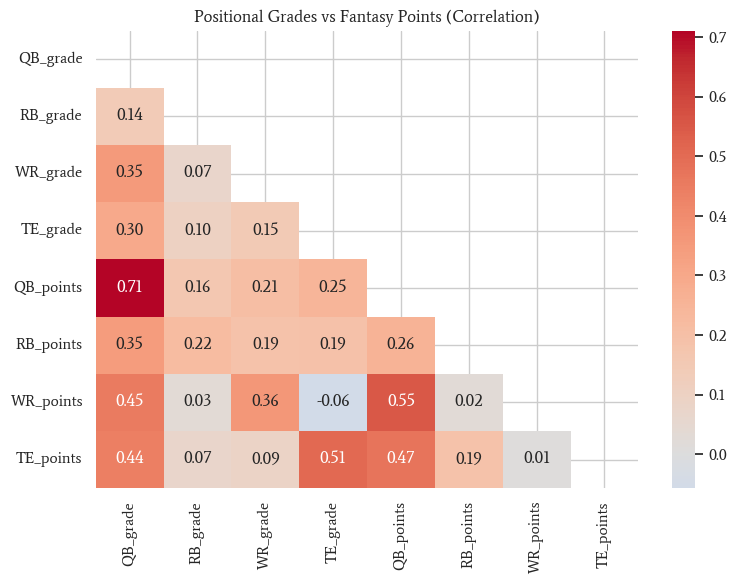

In [15]:
# select only the normalized grades and fantasy points
grade_cols = [f'{pos}_grade' for pos in positions]
point_cols = [f'{pos}_points' for pos in positions]

# compute correlation
correlations = grades[grade_cols + point_cols].corr()

# only keep the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlations, dtype=bool))
correlations = correlations.mask(mask)

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Positional Grades vs Fantasy Points (Correlation)')
plt.tight_layout()
plt.show()

- QB grade has a strong correlation with QB points scored.
- Higher QB grades generally have a positive effect on WR and TE points, with a more subtle effect on a RB.
- RB grade shows very little correlation, even with RB fantasy production. This supports how dependent this position is on OL strength.
- WR grade has a moderate corr with WR points.
- TE grade has a moderate/strong corr with TE points, showing that this position is less dependent on QB performance than WR (maybe due to YAC?)
- Since QB grade does have a correlation with fantasy points for other positions (especially WR), I will be adding this as a feature. For the 2025 season, we don't have the true QB grade. I will be using estimated grades derived from my other project, [Pass Forward](https://github.com/heefjones/pass_forward).

In [16]:
# load 2025 grade preds
qb_grades_2025 = pd.read_csv('./data/clean/qb_grades_2025.csv')[['player', 'QB_grade']]
qb_grades_2025 = clean_preds(qb_grades_2025)

# load rankings
rankings_2025 = pd.read_csv('./data/adp/adp_5-2.csv')
rankings_2025 = clean_rankings(rankings_2025)

# merge with rankings to get updated 2025 teams
qb = pd.merge(qb_grades_2025, rankings_2025[['teamName', 'player']], on='player', how='left')

# drop 2025 backup QBs who have higher proj grade than starters
backups = ['Kirk Cousins', 'Daniel Jones', 'Sam Howell', 'Derek Carr', 'Brandon Allen', 'Spencer Rattler']
qb = qb[~qb['player'].isin(backups)].reset_index(drop=True)

# add avg rookie grade for jj mccarthy, cam ward, and tyler shough
qb.loc[len(qb)] = {'player': 'JJ McCarthy', 'QB_grade': 70, 'teamName': 'MIN'}
qb.loc[len(qb)] = {'player': 'Cam Ward', 'QB_grade': 70, 'teamName': 'TEN'}
qb.loc[len(qb)] = {'player': 'Tyler Shough', 'QB_grade': 70, 'teamName': 'NO'}

# for each team, get the QB with the highest grade
starters = []
for team, group in qb.groupby('teamName'):
    top_qb = group.nlargest(1, 'QB_grade')
    starters.append(top_qb)

# combine results
starters = pd.concat(starters).reset_index(drop=True)

# add Year col
starters['Year'] = 2025

# rename teamName to Tm
starters = starters.rename(columns={'teamName': 'Tm'})

# combine with grades
all_grades = pd.concat([grades[['Tm', 'Year', 'QB_grade']], starters[['Tm', 'Year', 'QB_grade']]], ignore_index=True)

# export to csv
all_grades.to_csv('./data/clean/qb_grades.csv', index=False)

- The "QB_grade" feature will be used for non-QBs, hopefully picking up their QB's play in the season.
- It will be the only feature that captures data in the target season (next season), and the 2025 grades are predictions.

# Team Consistency

In [17]:
# sum points for each (Tm, Year) group in pos_points
team_points = pos_points.groupby(['Tm', 'Year'])['Points_half-ppr'].sum().reset_index().sort_values(['Tm','Year'])

def yoy_corr(grp):
    # compute correlation between this year’s pts and last year’s pts
    return grp['Points_half-ppr'].corr(grp['Points_half-ppr'].shift(1))

# apply per team
corr_df = (team_points.groupby('Tm').apply(yoy_corr, include_groups=False).reset_index(name='points_yoy_corr')).dropna()
corr_df.points_yoy_corr.mean()

0.48379198619274943

- Year-over-year, an offense has a correlation of 0.5 with its total fantasy production.

In [18]:
# top teams of 2024
team_points.query('Year == 2024').sort_values(by='Points_half-ppr', ascending=False).T

,541,128,1553,324,1636,184,596,1215,1465,904,85,1410,30,789,486,780,849,772,687,431,646,1276,717,269,1013,794,1581,1123,214,376,1068,958,1691
Tm,DET,BAL,TB,CIN,WAS,BUF,GB,PHI,SF,MIN,ATL,SEA,ARI,LAR,DEN,LAC,MIA,KC,IND,DAL,HOU,PIT,JAX,CHI,NO,LV,TEN,NYJ,CAR,CLE,NYG,NE,multiple
Year,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024
Points_half-ppr,1645.04,1581.26,1563.6,1516.72,1405.28,1365.52,1348.06,1342.18,1304.26,1296.66,1294.52,1265.86,1261.36,1224.44,1223.7,1216.42,1205.92,1184.54,1162.46,1161.72,1158.18,1124.58,1098.18,1090.78,1089.1,1082.62,1068.14,1056.24,1048.94,1044.26,1040.42,1021.82,820.74
